In [1]:
import os
import import_ipynb
import pandas as pd
import itertools
import talib
import math
import numpy as np
from numpy import nan

'''to be modified and shift into property files'''
currentpath=os.getcwd()
dbpath=os.path.join(currentpath,"..",'database')
stockcsv=os.path.join(dbpath,'stockpath.csv')
stocktest=os.path.join(dbpath,'stocktest.csv')

featurescsv=os.path.join(dbpath,'features.csv')
featuresdata=os.path.join(dbpath,'featuresdata.csv')



#to import Load_Csv file from another directory. this style is for jupyter notebook
                
%cd ..
from utility import Load_Csv as lcsv
%cd stockprediction



C:\Prgs\Code\mokshtech\Fin_Product
importing Jupyter notebook from C:\Prgs\Code\mokshtech\Fin_Product\utility\Load_Csv.ipynb
C:\Prgs\Code\mokshtech\Fin_Product\stockprediction


In [2]:
class ta(lcsv.Load_csv):
    '''this class contains functions fto predict label with the help of technical indicators'''
    
    def __init__(self,filename=stockcsv):
        self.filename=filename
    

    def loadcsv(self):
        '''load 'Date','Close', 'Volume' data from databse and return dataframe
        '''
        
        self.dataset=self.LoadData(self.filename).loc[:, ['Date','Close', 'Volume','Open']]
        self.dataset['Date'] = pd.to_datetime(self.dataset['Date'])
        return self.dataset
    

    def loadfeaturesdata(self,x):
        '''load features detailed data from databse'''
        self.featuresdata=self.LoadfeaData(featuresdata)
        self.featuresdata.index=self.featuresdata[0]
        #self.featuresdata=self.featuresdata.loc[x]
        return list(self.featuresdata.loc[x,1:])
    
    
    def ti_Combinations(self):
        '''takes input as list of list and  gives output as comninations '''
        
        #print("ti_Combinations")

        self.paneldict={}
        def comb_r(row):
            
            #print(self.dataset)
            #print('row',row)
            comb_dataset=self.dataset.copy()#deep=True)  #Copy basic dataset to comb_dataset
            for i in row:
                #print('i',i)
                comb_dataset['MA'+str(i)]=self.tdf['MA'+str(i)] # add MA rows from tdf to comb_dataset as per the combination .
                #print('comb_dataset',comb_dataset)
            #print('c',comb_dataset)    #To print dataset with all combinations of MA
            
            #print('self.paneldict',self.paneldict)
            row_s=str(row)
            self.paneldict[row_s]=comb_dataset.copy()#deep=True)  # Now xfer dataframe from comb_dataset to panel_dict 
            #print('self.paneldict2',self.paneldict)


        try:
            a=self.tidict['MA']
            #print('combinations_input',a)
            #[[10],[50],[60-64]]
            comb_df=pd.Series(list(itertools.product(*a)))##get combinatons 
            #print('comb_df',comb_df)
            comb_df.apply(comb_r)
            #panel_dataset=pd.Panel(self.paneldict)
            #print('panel_dataset',panel_dataset)
         
            '''
            ### Error: Panel is not working here . 
            On printing panel it is printing merge of all unique columns for each dataframe.
            
            
            #print(item for item in panel_dataset.items])  # to print item name of panel
            #print('(2, 4, 60)',panel_dataset[(2, 4, 60)])
            
            '''
            
            
        except Exception as e:
            print('e2',e)         
       
        
    def loadfeatures(self):
        '''load feature label data from databse
        '''
        self.featurestilist=[]
        self.misc=[]
        self.label=[]
        self.tilist=dir(talib)
        self.featuredict={}
        self.tidict={}
        self.features=self.LoadfeaData(featurescsv)

         
        def func(value,args):
           

            if str(value).find("-")>-1:   #tocheck if range is given 
                a,b=value.split("-")
                a=int(a)
                b=int(b)

                self.featuredict[args].extend(list(range(a,b)))   #if range is given then replace it by list
                self.tidict[args].append(list(range(a,b))) 

            else:
                try:
                    var=str(args)+'-'+str(int(value))              #togenerate name like MA-1,MA-2  

                    self.featuredict[args].extend(self.loadfeaturesdata(var))
                    
                    self.tidict[args].append(self.loadfeaturesdata(var))
                except Exception as e:
                    print('e1',e)    
        
        
        def funr(row):
            r_len=len(row)
            ti=row[0]
            rowdf=pd.Series(row[1:])
            
                     
            if ti in self.tilist:
                self.featuredict[ti]=[]
                self.tidict[ti]=[]
                self.featurestilist.append(ti)
                
                rowdf.apply(func,args=(ti,))    #Vectorize function over each element
                
            elif ti=='label':
                self.label.append(row[1])
            else:
                self.misc.append(row)
    
                
                                                 #vectorize approach to speed up process        
        self.features.apply(funr, axis=1)
        #print(self.featuredict)                  #To be removed after development
        #print(self.features)
        #print("end")
        
        
        
        #return(self.featurestilist,self.label,self.misc,self.MA_comb)
        
        
        
    def get_MA(self,x):
        malist=self.featuredict['MA']
        for i in malist:
            if ('MA'+str(i)) in self.tdf:
                continue
            else:          
                self.tdf['MA'+str(i)]=talib.SMA(self.dataset[x],i)
        return(self.tdf)
        
    def get_RSI(self,x):
        rsilist=self.featuredict['RSI']
        for i in rsilist:
            if ('RSI'+str(i)) in self.tdf:
                continue
            else:
                self.dataset['RSI'+str(i)]=talib.RSI(self.dataset[x],i)
        return(self.dataset)
        
        
        
    def get_technical_indi(self):
        
        self.tdf=self.LoadData(stockcsv).loc[:, ['Close']]
        for i in self.featurestilist:
            if i=='MA':
                self.get_MA('Close')
            if i=='RSI':
                self.get_RSI('Close')
                
                
    def get_return(self):
        self.dataset['Daily_Return'] = self.dataset['Close'].pct_change()
        
        
    def get_label(self):
        print("start technical analysis and  Calculate technical indicators")
        if self.label[0]=='return':
            self.get_return()
        #print(self.dataset)
        #print(self.tdf)
        #print(self.tidict)
       
    def get_panel_data(self):
        self.loadcsv()
        self.loadfeatures()
        self.get_technical_indi()
        self.get_label()
        self.ti_Combinations()
        return self.paneldict

        
        
        

In [3]:
# Part 2 - Building the RNN

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout


import matplotlib.pyplot as plt
from datetime import date
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

class ml_dpmodels(object):
    def data_preprocessing(self,train_paneldict):
    
        #print('data_preprocessing',train_paneldict)

        test_size=0.2 #b.test_size  #to split dataset in training and testing part.   

        layer=4


        df = train_paneldict.iloc[64:, 1:]
        #print('df',df)
        y = train_paneldict.iloc[64:, 1:2] #Close  # implement method to get label from file.
        #print(y)
        #feature scaling 
        self.sc = MinMaxScaler(feature_range = (0, 1))
        df_scaled = self.sc.fit_transform(df)
        y_scaled = self.sc.fit_transform(y)
        

        #Creating data sctructure for test and training
        X_train, X_test, y_train, y_test = train_test_split(df_scaled, y_scaled, test_size=test_size)
        X_train, y_train = np.array(X_train), np.array(y_train)


        print('Before reshaping','X_train :{0}, y_train :{1} ,X_test :{2} ,y_test :{3}'.format(X_train.shape, y_train.shape,X_test.shape, y_test.shape))

        #Reshape xtrain and xtest to fit in lstm model

        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        
        self.X_test , self.X_train , self.y_test , self.y_train = X_test , X_train , y_test , y_train 


        return(self.X_test,self.X_train,self.y_test,self.y_train)

        
    def build_predictmodel(self,dataframe):
        # Initialising the RNN
        
        
        LSTM_units=50
        LSTM_unit_increment=30
        dropoutunit=0.2
        
        
        X_test , X_train , y_test , y_train  = self.data_preprocessing(dataframe)
        
        
        regressor = Sequential()

        # Adding the first LSTM layer and some Dropout regularisation
        regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
        regressor.add(Dropout(0.2))


       # for i in range(3):
        #    print(i)
        LSTM_units=LSTM_units+LSTM_unit_increment
        print(LSTM_units)

        # Adding a second LSTM layer and some Dropout regularisation
        regressor.add(LSTM(units = LSTM_units, return_sequences = True))
        regressor.add(Dropout(dropoutunit))


        # Adding a third LSTM layer and some Dropout regularisation
        regressor.add(LSTM(units = 150, return_sequences = True))
        regressor.add(Dropout(0.2))

        # Adding a fourth LSTM layer and some Dropout regularisation
        regressor.add(LSTM(units = 200))
        regressor.add(Dropout(0.2))

        
        print(X_train.shape,y_train.shape)
        # Adding the output layer
        regressor.add(Dense(units = 1))

        # Compiling the RNN
        regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

        # Fitting the RNN to the Training set
        
        regressor.fit(X_train, y_train, epochs = 20, batch_size = 200)
        
        return(regressor,X_test , X_train , y_test , y_train)


    def predict_visualise(self,dataframe):
        
     
        train_paneldict=dataframe
        #print('predict_visualise',train_paneldict)
        
        # Part 3 - Making the predictions and visualising the results


        #real_stock_price = dataset_test.iloc[:, 1:2].values

        '''
        dataset_total = pd.concat((dataset_train_a['Close'], dataset_test['Close']), axis = 0)
        inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
        inputs = inputs.reshape(-1,1)
        inputs = sc.transform(inputs)
        X_test = []
        for i in range(60, 133):
            X_test.append(inputs[i-60:i, 0])

        X_test = np.array(X_test)

        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


        '''
        regressor,X_test , X_train , y_test , y_train=self.build_predictmodel(dataframe)

        predicted_stock_price = regressor.predict(X_test)
        predicted_stock_price = self.sc.inverse_transform(predicted_stock_price)
        y_test = self.sc.inverse_transform(y_test)



        print('p',predicted_stock_price[0:5])
        print('r',y_test[0:5])

        predicted_stock_price=predicted_stock_price[0:60]
        y_test=y_test[0:60]



            # Visualising the results
        width = 15
        height = 10
        plt.figure(figsize=(width, height))


        plt.plot(y_test, color = 'red', label = 'Real Nifty  Price')
        plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Nifty Stock Price')
        plt.title('Nifty Stock Price Prediction')
        plt.xlabel('Time')
        plt.ylabel('Nifty Stock Price')
        plt.legend()
        plt.grid(color='b', linestyle='--', linewidth=1)



        plt.show()




    
    
    


C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


e1 cannot convert float NaN to integer
start technical analysis and  Calculate technical indicators
Before reshaping X_train :(804, 9), y_train :(804, 1) ,X_test :(202, 9) ,y_test :(202, 1)
80
(804, 9, 1) (804, 1)
Epoch 1/20
804/804 [==============================] - 4s 5ms/step - loss: 0.2408
Epoch 2/20
804/804 [==============================] - 1s 1ms/step - loss: 0.0633
Epoch 3/20
804/804 [==============================] - 1s 1ms/step - loss: 0.0542
Epoch 4/20
804/804 [==============================] - 1s 2ms/step - loss: 0.0579
Epoch 5/20
804/804 [==============================] - 1s 2ms/step - loss: 0.0523
Epoch 6/20
804/804 [==============================] - 1s 2ms/step - loss: 0.0355
Epoch 7/20
804/804 [==============================] - 2s 2ms/step - loss: 0.0510
Epoch 8/20
804/804 [==============================] - 2s 2ms/step - loss: 0.0325
Epoch 9/20
804/804 [==============================] - 1s 2ms/step - loss: 0.0342
Epoch 10/20
804/804 [==============================] - 2s

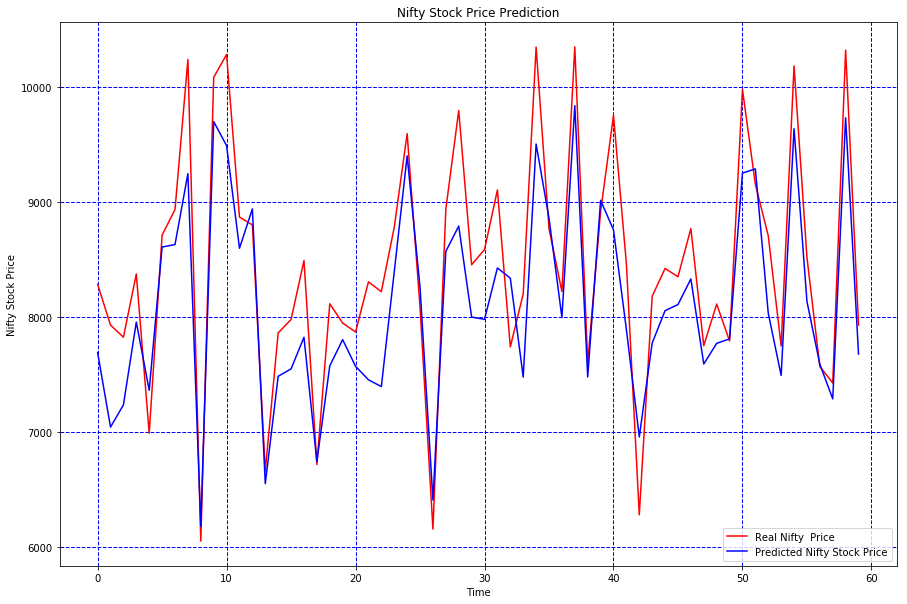

Before reshaping X_train :(804, 9), y_train :(804, 1) ,X_test :(202, 9) ,y_test :(202, 1)
80
(804, 9, 1) (804, 1)
Epoch 1/20
804/804 [==============================] - 6s 8ms/step - loss: 0.2409
Epoch 2/20
804/804 [==============================] - 1s 2ms/step - loss: 0.0618
Epoch 3/20
804/804 [==============================] - 1s 2ms/step - loss: 0.0427
Epoch 4/20
804/804 [==============================] - 1s 2ms/step - loss: 0.0368
Epoch 5/20
804/804 [==============================] - 1s 2ms/step - loss: 0.0333
Epoch 6/20
804/804 [==============================] - 1s 2ms/step - loss: 0.0288
Epoch 7/20
804/804 [==============================] - 1s 2ms/step - loss: 0.0217
Epoch 8/20
804/804 [==============================] - 1s 2ms/step - loss: 0.0176
Epoch 9/20
804/804 [==============================] - 1s 2ms/step - loss: 0.0134
Epoch 10/20
804/804 [==============================] - 1s 2ms/step - loss: 0.0116
Epoch 11/20
804/804 [==============================] - 1s 2ms/step - loss: 

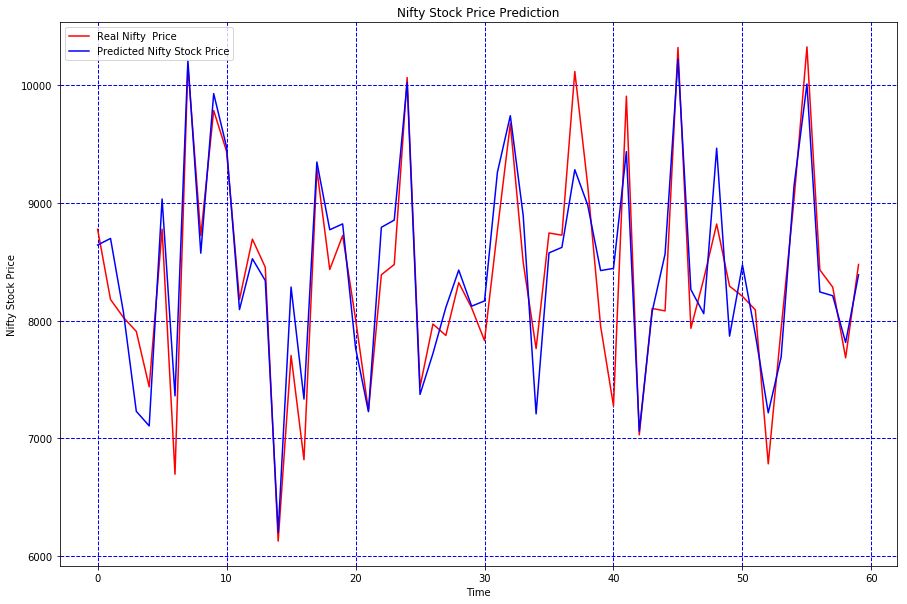

Before reshaping X_train :(804, 9), y_train :(804, 1) ,X_test :(202, 9) ,y_test :(202, 1)
80
(804, 9, 1) (804, 1)
Epoch 1/20
804/804 [==============================] - 7s 8ms/step - loss: 0.2289
Epoch 2/20
804/804 [==============================] - 1s 2ms/step - loss: 0.0736
Epoch 3/20
804/804 [==============================] - 1s 2ms/step - loss: 0.0447
Epoch 4/20
804/804 [==============================] - 1s 2ms/step - loss: 0.0468
Epoch 5/20
804/804 [==============================] - 1s 2ms/step - loss: 0.0294
Epoch 6/20
804/804 [==============================] - 1s 2ms/step - loss: 0.0278
Epoch 7/20
804/804 [==============================] - 1s 2ms/step - loss: 0.0275
Epoch 8/20
804/804 [==============================] - 1s 2ms/step - loss: 0.0224
Epoch 9/20
804/804 [==============================] - 1s 2ms/step - loss: 0.0207
Epoch 10/20
804/804 [==============================] - 1s 2ms/step - loss: 0.0178
Epoch 11/20
804/804 [==============================] - 1s 2ms/step - loss: 

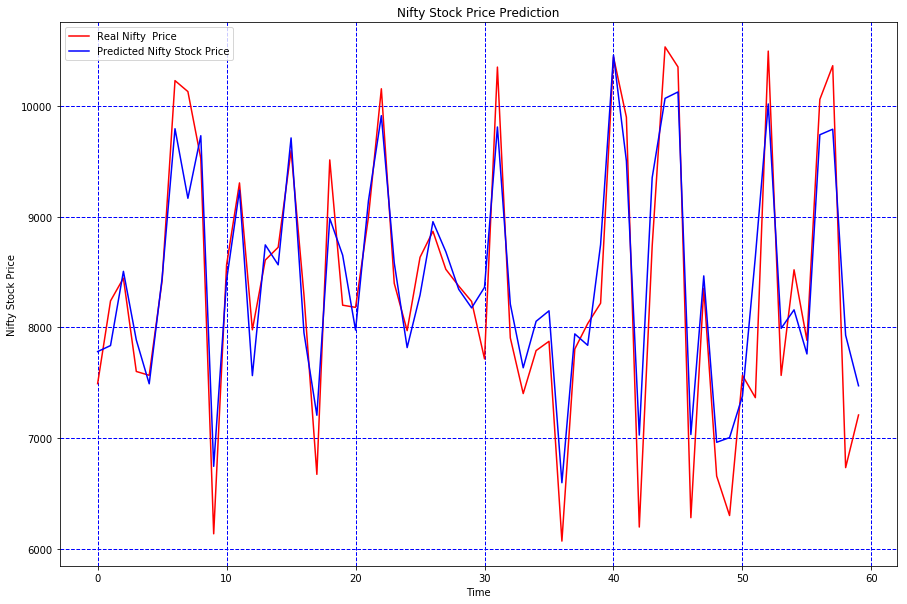

Before reshaping X_train :(804, 9), y_train :(804, 1) ,X_test :(202, 9) ,y_test :(202, 1)
80
(804, 9, 1) (804, 1)
Epoch 1/20
804/804 [==============================] - 7s 9ms/step - loss: 0.2491
Epoch 2/20
804/804 [==============================] - 1s 2ms/step - loss: 0.0647
Epoch 3/20
804/804 [==============================] - 1s 2ms/step - loss: 0.0455
Epoch 4/20
804/804 [==============================] - 1s 2ms/step - loss: 0.0523
Epoch 5/20
804/804 [==============================] - 1s 2ms/step - loss: 0.0342
Epoch 6/20
804/804 [==============================] - 1s 2ms/step - loss: 0.0293
Epoch 7/20
804/804 [==============================] - 1s 2ms/step - loss: 0.0299
Epoch 8/20
804/804 [==============================] - 1s 2ms/step - loss: 0.0283
Epoch 9/20
804/804 [==============================] - 1s 2ms/step - loss: 0.0256
Epoch 10/20
804/804 [==============================] - 1s 2ms/step - loss: 0.0270
Epoch 11/20
804/804 [==============================] - 1s 2ms/step - loss: 

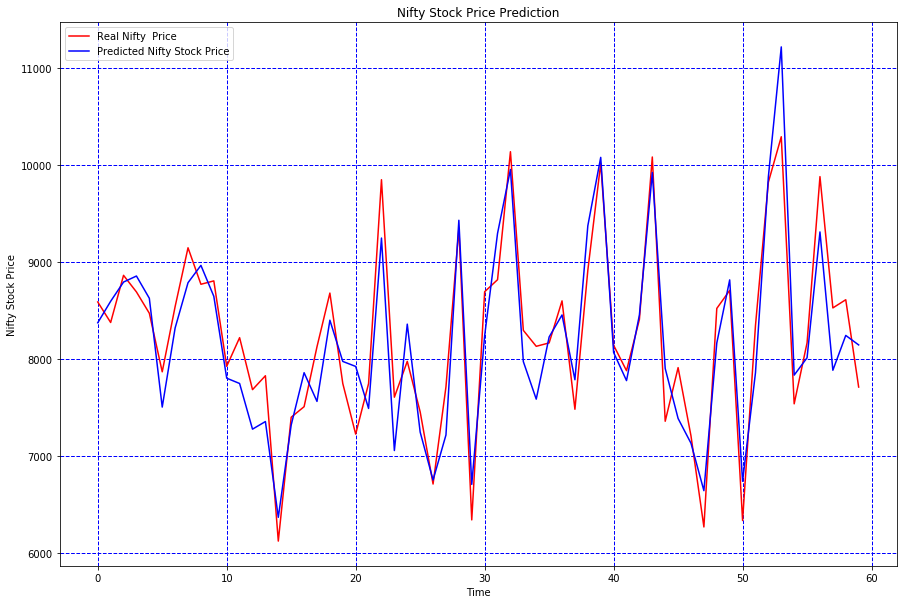

Before reshaping X_train :(804, 9), y_train :(804, 1) ,X_test :(202, 9) ,y_test :(202, 1)
80
(804, 9, 1) (804, 1)
Epoch 1/20
804/804 [==============================] - 8s 9ms/step - loss: 0.2464
Epoch 2/20
804/804 [==============================] - 1s 2ms/step - loss: 0.0730
Epoch 3/20
804/804 [==============================] - 1s 2ms/step - loss: 0.0388
Epoch 4/20
804/804 [==============================] - 1s 2ms/step - loss: 0.0472
Epoch 5/20
804/804 [==============================] - 1s 2ms/step - loss: 0.0313
Epoch 6/20
804/804 [==============================] - 1s 2ms/step - loss: 0.0290
Epoch 7/20
804/804 [==============================] - 2s 2ms/step - loss: 0.0279
Epoch 8/20
804/804 [==============================] - 2s 2ms/step - loss: 0.0225
Epoch 9/20
804/804 [==============================] - 2s 2ms/step - loss: 0.0200
Epoch 10/20
804/804 [==============================] - 2s 2ms/step - loss: 0.0161
Epoch 11/20
804/804 [==============================] - 2s 2ms/step - loss: 

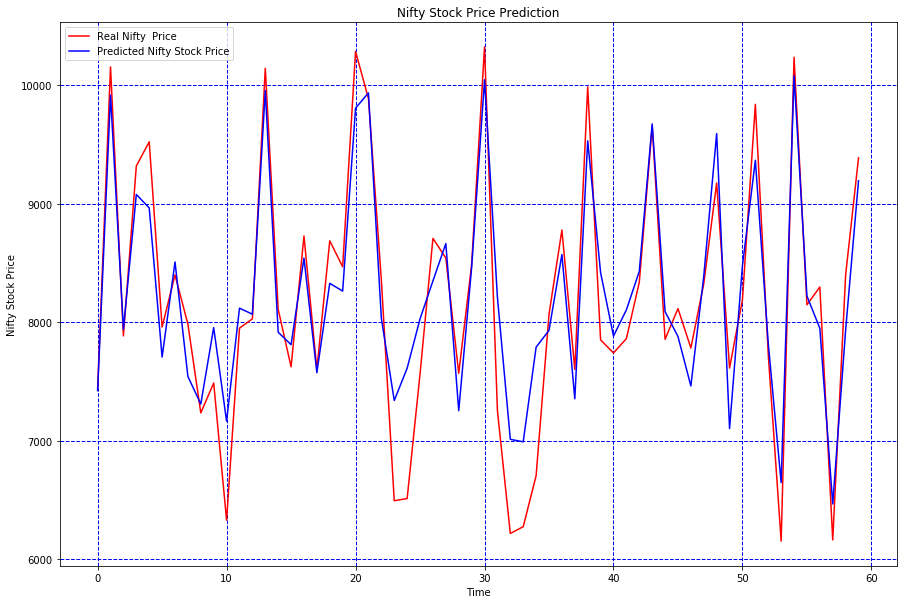

In [9]:
def start_run(dataframe):
    t=ml_dpmodels()
    t.predict_visualise(dataframe)

b=ta()
data=b.get_panel_data()


d2 = dict((k, start_run(v)) for k,v in data.items())




